In [1]:
from spline_learner_poe4d_MM import *
from spline_learner_poe_old import *
import matplotlib.pyplot as plt

np.random.seed(1)

/Users/jendawk/Documents/GeorgTravisRot/POE_learner/helper.py:3: RuntimeWarning: overflow encountered in exp
  y = yscale/(1+np.exp(-xscale*(t)))
/Users/jendawk/Documents/GeorgTravisRot/POE_learner/spline_learner_poe4d.py:60: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.true_betas = [np.linalg.lstsq(self.true_bmat1[i], Y_est[i])[0] for i in range(self.num_mice)]


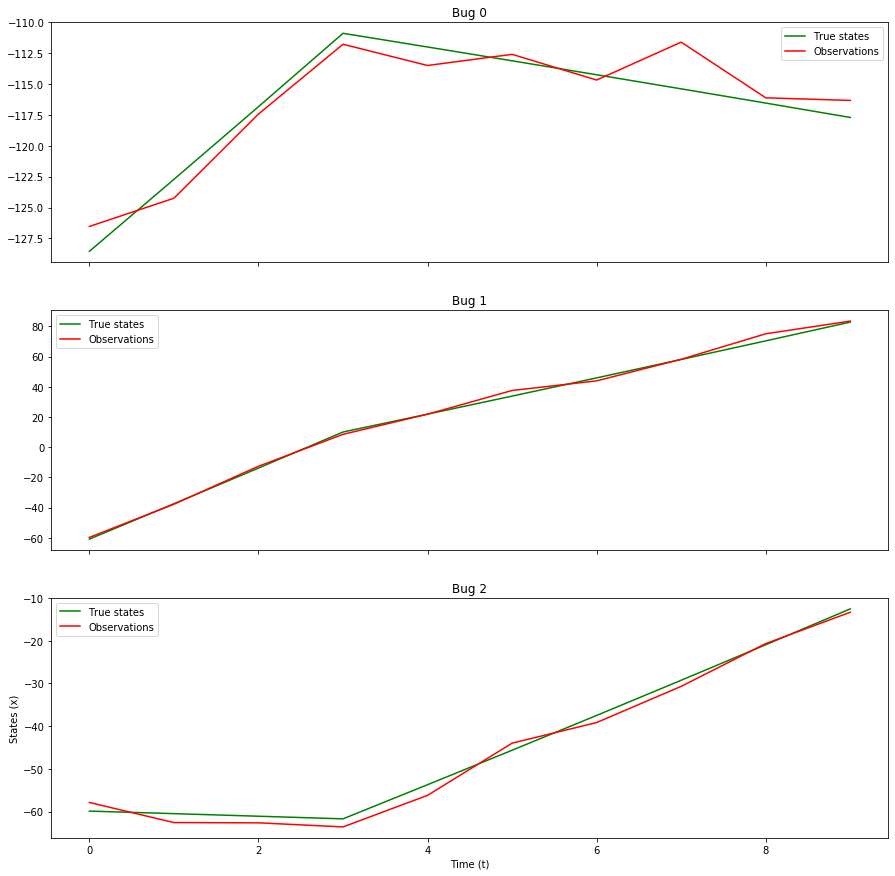

/Users/jendawk/Documents/GeorgTravisRot/POE_learner/spline_learner_poe4d.py:177: RuntimeWarning: overflow encountered in exp
  prob_keep = np.exp(np.sum(num,0) - np.sum(dem,0))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/_multivariate.py:660: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/Users/jendawk/Documents/GeorgTravisRot/POE_learner/spline_learner_poe4d.py:203: RuntimeWarning: overflow encountered in exp
  prob_keep = np.exp(np.sum(num, 0) - np.sum(dem, 0))


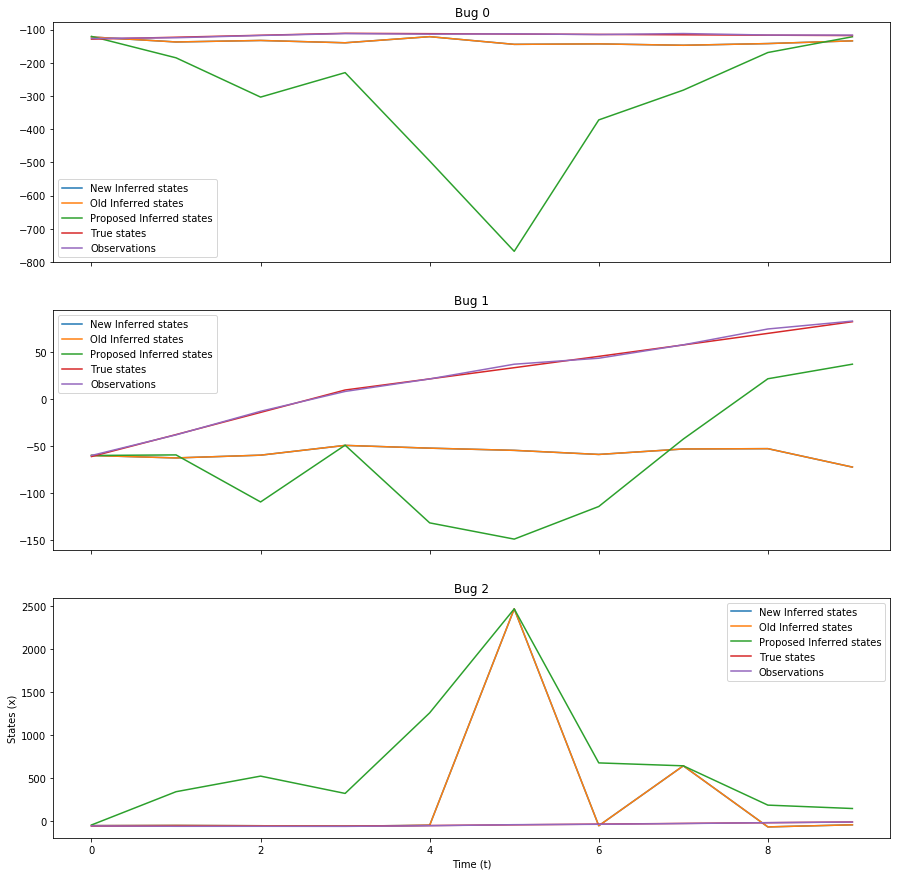

> /Users/jendawk/Documents/GeorgTravisRot/POE_learner/spline_learner_poe4d.py(234)px2()
-> part1=[-.5*(sigmoid2d(xin, a, b)-f1a)[:,i].T@np.linalg.inv(
(Pdb) c
> /Users/jendawk/Documents/GeorgTravisRot/POE_learner/spline_learner_poe4d.py(239)px2()
-> return part1 + part2
(Pdb) part1
[-292.7353718689302, -1148.4789582452006, -40622391.98162953]
(Pdb) a
self = <spline_learner_poe4d.SplineLearnerPOE_4D object at 0x12c3e0fd0>
states = array([[-121.94528293,  -59.77533557,  -54.80634202],
       [-136.99297151,  -62.38938852,  -52.42296265],
       [-132.46672133,  -59.4406212 ,  -56.22193763],
       [-139.44013045,  -49.02176411,  -61.12919184],
       [-120.99504497,  -51.96716803,  -50.72212096],
       [-144.18924047,  -54.30826012, 2469.39472309],
       [-142.77712803,  -58.66426951,  -56.33176073],
       [-146.97129522,  -52.85049053,  641.53790087],
       [-141.83528142,  -52.49662466,  -69.78074031],
       [-133.62707711,  -72.159808  ,  -45.44372911]])
theta = [array([[ -24.863

BdbQuit: 

In [2]:
spl = SplineLearnerPOE_4D()
spl.run(gibbs_steps = 500, train_f1 = False)

In [ ]:
spl.trace_a = []
spl.trace_b =[]
spl.trace_x=[]
spl.trace_f1=[]
spl.trace_f2=[]
spl.trace_beta=[]

# for i, y in enumerate(spl.observations):
i = 0

x0 = np.random.normal(spl.observations[0,:,i], np.sqrt(100))
x = np.random.normal(x0, 10, size=(spl.num_states, spl.num_bugs))

f1 = np.random.normal(0, np.sqrt(spl.theta_var), size=(spl.num_states-1, spl.num_bugs))
f2 = np.random.normal(0, np.sqrt(spl.theta_var), size=(spl.num_states-1, spl.num_bugs))




# theta_2 = [st.multivariate_normal(np.zeros(spl.num_bugs**2), spl.avar*np.eye(spl.num_bugs**2)).rvs(),
#            st.multivariate_normal(np.zeros(spl.num_bugs**2), spl.bvar*np.eye(spl.num_bugs**2)).rvs()]
# theta_2 = [np.random.normal(0,np.sqrt(spl.avar)), np.random.normal(0,np.sqrt(spl.bvar))]

mu_post, sig_post = spl.update_theta(x,f2)
betas = st.multivariate_normal(mu_post, sig_post*np.eye(sig_post.shape[0])).rvs()
# betas = st.multivariate_normal(mu_theta_n, sig_theta).rvs()

y = spl.observations[:,:,i]
xnew = spl.update_x(x, y, x0, betas, theta_2)

xin = x[:-1,:]

f1 = xin.flatten(order = 'F') + spl.dt*(xin.flatten(order = 'F')*spl.gr + betas@spl.calc_bmat(xin).T)

theta2_n = spl.update_f2(x,theta_2,f1)

pvar = spl.update_pvar(x[1:,:].flatten(order = 'F'),f1.flatten(order = 'F'))

poe_var = spl.update_poe(f1.flatten(order = 'F'),f2.flatten(order = 'F'))


In [ ]:
def diag_mat(X):
    out = np.zeros((len(X)*X[0].shape[0], len(X)*X[0].shape[1]))
    for i in range(len(X)):
        out[i*X[0].shape[0]:(i+1)*X[0].shape[0],i*X[0].shape[1]:(i+1)*X[0].shape[1]] = X[i]
    return out

In [38]:
bmat.shape

(30, 72)

In [37]:
(spl.dt*bmat.T@np.linalg.inv(spl.pvar*spl.dt)@bmat*spl.dt).shape

(72, 72)

In [70]:
bmat = diag_mat(bmat_full)
mu_thetas = spl.mu_betas.flatten(order='F')

g1 = bmat@mu_thetas

sig_post = np.linalg.inv((1/spl.theta_var)*np.eye(bmat.shape[1]) + spl.dt*bmat.T@np.linalg.inv(spl.pvar*spl.dt)@bmat*spl.dt + spl.dt*bmat.T@np.linalg.inv(spl.poe_var)@bmat*spl.dt)

Y_est = x[1:,:]-x[:-1,:] - spl.gr*x[:-1,:]*spl.dt
Y_est = Y_est.flatten(order = 'F')

f1_flat = f1[1:,:].flatten(order = 'F')

mu_post = (((1/spl.theta_var)*np.eye(bmat.shape[1]))@mu_thetas + (bmat.T@np.linalg.inv(spl.pvar*spl.dt))@(Y_est*spl.dt)+ (bmat.T@np.linalg.inv(spl.poe_var))@((spl.dt**2)*f1_flat))@sig_post

In [68]:
(bmat.T@np.linalg.inv(spl.poe_var))@((spl.dt**2)*f1)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 11 is different from 30)

In [65]:
(bmat.T@np.linalg.inv(spl.pvar*spl.dt))@(Y_est*spl.dt)

array([ 0.        , -0.04363053,  0.        , -0.0218334 , -0.08575386,
        0.        ,  0.        ,  0.        ,  0.        , -0.17455505,
       -0.11598481, -0.03201104,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.08693128, -0.00702724,  0.20460389,
        0.1007608 ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.06327495,  0.07795395,  0.02179614,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.04245447,
       -0.12407414, -0.17915542,  0.        ,  0.        ,  0.        ,
        0.        , -0.05329083,  0.000652  ,  0.05504823,  0.03699756,
        0.        ,  0.        ,  0.        ,  0.        , -0.02426115,
       -0.00169417,  0.00092538, -0.03202021,  0.        ,  0.        ,
        0.        ,  0.        , -0.05847933,  0.14383547,  0.04040349,
        0.05232234,  0.        ,  0.        ,  0.        ,  0.        ,
        0.17144547,  0.02751666,  0.        ,  0.        ,  0.  

In [64]:
(Y_est*spl.dt).shape

(30,)

In [63]:
(bmat.T@np.linalg.inv(spl.pvar*spl.dt)).shape

(72, 30)

In [56]:
np.linalg.inv(spl.pvar*spl.dt).shape

(30, 30)

In [157]:
Y_est = x[1:,:]-x[:-1,:] - spl.gr*x[:-1,:]*spl.dt
Y_est = Y_est.flatten(order = 'F')

In [158]:
Y_est.shape

(30,)

In [159]:
bmat_full.shape

(30, 216)

In [151]:
bmat = np.reshape(bmat,(bmat.shape[0],bmat.shape[1]*bmat.shape[2]*bmat.shape[3]), order = 'F')

bmat_full = diag_block_mat(bmat,bmat.shape[0]*spl.num_bugs)

mu_thetas = spl.mu_betas.flatten(order='F')

Y_est = x[1:,:]-x[:-1,:] - spl.gr*x[:-1,:]*spl.dt
Y_est.flatten(order = 'F')

# g1 = mu_thetas@bmat_full

# # sig_proc = np.linalg.inv(spl.pvar*np.eye(spl.num_bugs**2,spl.num_bugs**2)*spl.dt)

# sig_out = spl.theta_var + (spl.dt**2)*bmat_full.T@sig_proc@bmat_full+ (spl.dt**2)*bmat_full.T@spl.poe_var@bmat_full

IndexError: tuple index out of range

In [54]:
states = x

bmat2 = spl.calc_bmat(states[:-1])
bmat = np.reshape(bmat2,(spl.num_bugs**2,bmat2.shape[-1],bmat2.shape[0]))

mu = np.reshape(spl.mu_betas,(spl.mu_betas.shape[0],spl.num_bugs**2))
# sig = spl.theta_var*np.eye(spl.num_knots,spl.num_knots)

identity_3d = np.zeros((spl.num_bugs**2,spl.num_knots,spl.num_knots,spl.num_bugs**2))
np.einsum('ijji->ij', identity_3d)[:] = 1
sig = spl.theta_var*identity_3d

sig_proc = np.linalg.inv(spl.pvar*np.eye(spl.num_bugs**2,spl.num_bugs**2)*spl.dt)

# m = np.reshape(mu,mu.shape[0]*mu.shape[1])
m,mu_d1,mu_d2 = mu_shape1d(mu)

smat, d1,d2 = shape2d(sig)
s = np.linalg.inv(smat)
# s = np.linalg.inv(np.reshape(sig,(spl.num_bugs**2*spl.num_knots,spl.num_bugs**2*spl.num_knots)))
one_m = m@s
# one_m = (mu.T@np.linalg.inv(sig)).T
two_m,_,_ = mu_shape1d(sig_proc@np.reshape(np.einsum('li,lijk -> ijk',x[1:,:] - x[:-1,:] - spl.dt*spl.gr*x[:-1,:], bmat2)*spl.dt,(spl.num_bugs**2,spl.num_knots)))
# two_m = np.reshape(np.einsum('li,lijk -> ijk',x[1:,:] - x[:-1,:] - spl.dt*spl.gr*x[:-1,:], bmat2)*spl.dt,(spl.mu_betas.shape[0],spl.num_bugs**2))@sig_proc
three_m,_,_ = mu_shape1d(np.reshape(np.einsum('li,lijk -> ijk',np.linalg.inv(spl.poe_var)@f2[:-1,:]*(spl.dt**2),bmat2),(spl.num_bugs**2,spl.num_knots)))
# three_m = np.reshape(np.einsum('li,lijk -> ijk',np.linalg.inv(spl.poe_var)@f2[:-1,:]*(spl.dt**2),bmat2),(spl.mu_betas.shape[0],spl.num_bugs**2))

# one_s = (spl.dt**2)*bmat.T@np.linalg.inv(sig_proc*spl.dt)@bmat + (spl.dt**2)*bmat@np.linalg.inv(spl.poe_var)@bmat.T

one_s = np.tensordot(np.matmul(bmat.T,np.linalg.inv(sig_proc*spl.dt)).T,bmat.T,1)
two_s = np.tensordot(np.matmul(bmat,np.linalg.inv(spl.poe_var)),bmat.T,1)*(spl.dt**2)

os,o1,o2 = shape2d(one_s)
ts,t1,t2 = shape2d(two_s)
sig_post = np.linalg.inv(s+os+ts)

mu_post = sig_post@(one_m+two_m+three_m)

# sig = np.reshape(s,(spl.num_bugs**2,spl.num_knots,spl.num_knots,spl.num_bugs**2))
sig_post_4d = shape3d(sig_post,d1,d2)

mu_post_2d = mu_shape2d(mu_post, mu_d1,mu_d2)

ValueError: operands could not be broadcast together with shapes (3,3) (9,8,8,9) 

In [143]:
def update_theta(x,f2):
    # bmat = spl.calc_bmat(states)
    bmat2 = spl.calc_bmat(states[:-1])
    bmat = np.reshape(bmat2,(spl.num_bugs**2,bmat2.shape[-1],bmat2.shape[0]))

    mu = np.reshape(spl.mu_betas,(spl.mu_betas.shape[0],spl.num_bugs**2))
    sig = spl.theta_var*np.eye(spl.num_knots,spl.num_knots)

    sig_proc = np.linalg.inv(spl.pvar*np.eye(spl.num_bugs**2,spl.num_bugs**2)*spl.dt)

    one_m = (mu.T@np.linalg.inv(sig)).T
    two_m = np.reshape(np.einsum('li,lijk -> ijk',x[1:,:] - x[:-1,:] - spl.dt*spl.gr*x[:-1,:], bmat2)*spl.dt,(spl.mu_betas.shape[0],spl.num_bugs**2))@sig_proc
    three_m = np.reshape(np.einsum('li,lijk -> ijk',np.linalg.inv(spl.poe_var)@f2[:-1,:]*(spl.dt**2),bmat2),(spl.mu_betas.shape[0],spl.num_bugs**2))

    # one_s = (spl.dt**2)*bmat.T@np.linalg.inv(sig_proc*spl.dt)@bmat + (spl.dt**2)*bmat@np.linalg.inv(spl.poe_var)@bmat.T

    one_s = np.sum(np.sum(np.tensordot(np.matmul(bmat.T,np.linalg.inv(sig_proc*spl.dt)).T,bmat.T,1),0),-1)
    two_s = np.sum(np.sum(np.tensordot(np.matmul(bmat,np.linalg.inv(spl.poe_var)),bmat.T,1),0),-1)*(spl.dt**2)

    sig_post = np.linalg.inv(np.linalg.inv(sig) + one_s + two_s)

    mu_post = sig_post@(one_m + two_m + three_m)
    return mu_post, sig_post

In [242]:
spl.trace_a = []
spl.trace_b =[]
spl.trace_x=[]
spl.trace_f1=[]
spl.trace_f2=[]
spl.trace_beta=[]

# for i, y in enumerate(spl.observations):
i = 0

x0 = np.random.normal(spl.observations[0,:,i], np.sqrt(100))
x = np.random.normal(x0, 10, size=(spl.num_states + 1, spl.num_bugs))

f1 = np.random.normal(0, np.sqrt(spl.theta_var), size=(spl.num_states + 1, spl.num_bugs))
f2 = np.random.normal(0, np.sqrt(spl.theta_var), size=(spl.num_states + 1, spl.num_bugs))

theta2 = [np.random.normal(0,np.sqrt(spl.avar)), np.random.normal(0,np.sqrt(spl.bvar))]

s = 0

mu_theta_n, sig_theta = update_theta(x,f2)
betas = st.multivariate_normal(mu_post, sig_post*np.eye(sig_post.shape[0])).rvs()
# betas = st.multivariate_normal(mu_theta_n, sig_theta).rvs()
xnew = spl.update_x(x, y, x0, betas, theta_2)

# spl.pvar = spl.update_pvar(x,f1)
# spl.poe_var = spl.update_poe(f1,f2)

ValueError: the input matrix must be positive semidefinite

In [ ]:
spl.trace_a = []
spl.trace_b =[]
spl.trace_x=[]
spl.trace_f1=[]
spl.trace_f2=[]
spl.trace_beta=[]

for i, y in enumerate(spl.observations):
    x0 = spl.states[i][0]
    x = np.random.normal(x0, 10, size=spl.states.shape[-1])

    f1 = np.random.normal(0, np.sqrt(spl.theta_var), size=spl.states.shape[-1])
    f2 = np.random.normal(0, np.sqrt(spl.theta_var), size=spl.states.shape[-1])
    if train_var:
        # import pdb; pdb.set_trace()
        # spl.mvar = spl.update_mvar(x,y)
        spl.pvar = spl.update_pvar(x,f1)
        spl.poe_var = spl.update_poe(f1,f2)
        # import pdb
        # pdb.set_trace()

    if plot:
        plt.figure()
        plt.title('Random starting states')
        plt.plot(x,label = 'Random starting states')
        plt.plot(spl.states[i], label='True states')
        plt.plot(spl.observations[i],label = 'Observations')
        plt.xlabel('Time (t)')
        plt.ylabel('States (x)')
        plt.legend()
        plt.show()
    # x = np.insert(spl.observations[i][1:], 0, x0) + np.random.normal(0, spl.mvar, size=spl.states[0].shape[0])
    if not train_x:
        # x = np.insert(spl.observations[i][1:],0,x0) + np.random.normal(0, 1,size = spl.states[0].shape[0])
        x = spl.states[i]
    theta2 = [np.random.normal(0,np.sqrt(spl.avar)), np.random.normal(0,np.sqrt(spl.bvar))]
    # spl.poe_var = (1e7)*np.eye(len(spl.states[0]))
    betavec = []
    xxvec = []
    f2vec = []
    avec=[]
    bvec=[]
    f1vec=[]
    import time
    end_ = [True]
    for s in range(gibbs_steps):
        end_.append(True)
        start = time.time()
        # Update theta 1
        end1 = time.time()
        if train_f1:
            # spl.pvar = 1
            mu_theta_n, sig_theta = spl.update_theta(x,f2)
            betas = st.multivariate_normal(mu_theta_n.squeeze(), sig_theta).rvs()
            if s > 0:
                if sum(abs(mu_theta_n-mu_theta))>=.0001:
                    end_[-1] = False

            mu_theta = mu_theta_n

        else:
            betas = spl.true_betas[i]
        # print('update theta: ' + str(end1-start))
        if s % spl.plot_iter == 0 and train_f1 and plot:
            plt.figure()
            plt.title('Observation ' + str(i) + ', Step ' + str(s))
            plt.plot(mu_theta,label = r'Inferred $\mu_{\theta_{1}}$')
            plt.plot(betas, label=r'Sampled $\theta_{1}$ from inferred $\mu_{\theta_{1}}$ and $\Sigma_{\theta_{1}}$')
            plt.plot(spl.true_betas[i], label=r'True $\theta_{1}$')
            plt.xlabel(r'$\theta_{1}$ index')
            plt.ylabel(r'$\theta_{1}$')
            plt.legend()
            plt.show()

        # spl.poe_var = 1*np.eye(len(spl.states[0]))
        # Update x based on theta 1

        # f1_part = betas@spl.calc_bmat(x[:-1]).T
        if train_x:
            # if s < 20:
            #     spl.pvar = 1e7
            xnew = spl.update_x(x, y, x0, betas, theta_2)
            if sum(abs(x-xnew))>=.0001:
                end_[-1] = False
                # import pdb; pdb.set_trace()
            x = xnew

        f1 = x + spl.dt*(betas@spl.calc_bmat(x).T)                
        end2 = time.time()
        if s % spl.plot_iter == 0 and train_x and plot:
            plt.figure()
            plt.title('Observation ' + str(i) + ', Step ' + str(s))
            plt.plot(xnew,label = 'Inferred states')
            plt.plot(spl.states[i], label='True states')
            plt.plot(spl.observations[i],label = 'Observations')
            plt.xlabel('Time (t)')
            plt.ylabel('States (x)')
            plt.legend()
            plt.show()
        # print('update x: ' + str(end2-start))
        # Calculate f1 based on x and theta 1

        if s % spl.plot_iter == 0 and (train_f1 or train_x) and plot:
            plt.figure()
            plt.title('Observation ' + str(i) + ', Step ' + str(s))
            plt.plot(x, f1,label = r'Inferred $f_{1}$')
            plt.plot(spl.states[i],spl.states[i] + spl.dt*(spl.true_betas[i]@spl.true_bmat2[i].T), label=r'True $f_{1}$')
            # plt.plot(spl.ys[i], label=r'True $f_{1}$')
            plt.xlabel('x (latent states)')
            plt.ylabel(r'$f_{1}(x)$')
            plt.legend()
            plt.show()

            # plt.figure()
            # plt.title('Observation ' + str(i) + ', Step ' + str(s))
            # plt.plot((x[1:]-x[:-1])/spl.dt, betas@spl.calc_bmat(x[:-1]).T,label = r'Inferred $\theta_{1} B_{xin}$')
            # plt.plot((spl.states[i][1:]-spl.states[i][:-1])/spl.dt, spl.true_betas[i]
            #          @spl.true_bmat1[i].T, label=r'True $\theta_{1} B_{xin}$')
            # # plt.plot(spl.ys[i], label=r'True $f_{1}$')
            # plt.xlabel(r'$(x_{i+1}-x_{i})/\Delta t)$')
            # plt.ylabel(r'$\theta_{1} B_{xin}$')
            # plt.legend()
            # plt.show()

            plt.figure()
            plt.title('Observation ' + str(i) + ', Step ' + str(s))
            plt.plot(x[:-1],(betas@spl.calc_bmat(x[:-1]).T), label=r'Inferred $\theta_{1} B_{xin}$')
            plt.plot(spl.states[i][:-1],spl.true_betas[i]@spl.true_bmat1[i].T, label=r'True $\theta_{1} B_{xin}$')
            # plt.plot(spl.true_betas[i]@spl.true_bmat1[i].T, label=r'True $\theta_{1} B_{xin}$')
            # plt.plot(spl.ys[i], label=r'True $f_{1}$')
            plt.xlabel('x')
            plt.ylabel(r'$\theta_{1} B_{xin}$')
            plt.legend()
            plt.show()

        end_bmat = time.time()
        # print('make f1: ' + str(end_bmat-start))
        # Update f2 based on f1, x
        if train_f2:
            theta2_n = spl.update_f2(x,theta2,f1)
            f2 = x + spl.dt*sigmoid(x, theta2[0], theta2[1])
            if sum(abs(np.array(theta2_n)-np.array(theta2)))>=0.0001:
                end_[-1] = False
                # import pdb
                # pdb.set_trace()
            theta2 = theta2_n
        else:
            f2 = x + spl.dt*sigmoid(x, spl.true_a, spl.true_b)
        end3 = time.time()
        # print('update theta 2: ' + str(end3-start))
        if s % spl.plot_iter == 0 and train_f2 and plot:
            plt.figure()
            plt.title('Observation ' + str(i) + ', Step ' + str(s))
            plt.plot(x,f2,label = r'Inferred $f_{2}$')
            plt.plot(spl.states[i],spl.states[i] + spl.dt*sigmoid(spl.states[i],spl.true_a,spl.true_b), label=r'True $f_{2}$')
            plt.xlabel('x')
            plt.ylabel('$f_{2}$')
            plt.legend()
            plt.show()

            # plt.figure()
            # plt.title('Observation ' + str(i) + ', Step ' + str(s))
            # plt.plot((x[1:]-x[:-1])/spl.dt, sigmoid(x[:-1],theta2[0],theta2[1]),
            #          label=r'Inferred')
            # plt.plot((spl.states[i][1:]-spl.states[i][:-1])/spl.dt, sigmoid(
            #     spl.states[i][:-1], spl.true_a, spl.true_b), label=r'True')
            # plt.xlabel(r'$(x_{i+1}-x_{i})/\Delta t)$')
            # plt.ylabel(r'$sigmoid(x_{i},\theta_{2})$')
            # plt.legend()
            # plt.show()

            plt.figure()
            plt.title('Observation ' + str(i) + ', Step ' + str(s))
            plt.plot(x[:-1],sigmoid(x[:-1], theta2[0], theta2[1]),label=r'Inferred')
            plt.plot(spl.states[i][:-1],sigmoid(spl.states[i][:-1],spl.true_a,spl.true_b))
            # plt.plot(sigmoid(spl.states[i][:-1], spl.true_a, spl.true_b), label=r'True')
            plt.xlabel('x')
            plt.ylabel(r'$sigmoid(x_{i},\theta_{2})$')
            plt.legend()
            plt.show()
            print(theta2)
        if s % spl.plot_iter == 0 and train_var:
            print('Step ' + str(s))
            print('Meas Var:' + str(spl.mvar))
            print('Proc Var:' + str(spl.pvar))
            print('POE Var:' + str(spl.poe_var[0][0]))
        if train_var:
            # spl.mvar = spl.update_mvar(x, y)
            spl.pvar = spl.update_pvar(x, f1)
            spl.poe_var = spl.update_poe(f1, f1)

        betavec.append(betas)
        f1vec.append(f1)
        avec.append(theta2[0])
        bvec.append(theta2[1])
        xxvec.append(x)
        f2vec.append(f2)
        end = time.time()
        # print(str(s) + ' gibbs loop: ' + str(end-start))
        # print('step ' + str(s))
        if len(end_)>50:
            if all(end_[-50:]) == True:
                print('Converged')
                break

    spl.trace_a.append(avec)
    spl.trace_b.append(bvec)
    spl.trace_x.append(xxvec)
    spl.trace_f1.append(f1vec)
    spl.trace_f2.append(f2vec)
    spl.trace_beta.append(betavec)
    # import pdb; pdb.set_trace()
    print('Observation ' + str(i) + ' Complete')
